# Epoch Task

## Multimodal Emotion Recognition from Audio and Transcript

Importing required libraries

In [10]:
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import librosa.display 
import os
import torch
import json
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


# Download latest version of dataset
path_dataset = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")

#use cuda
if torch.cuda.is_available():
    device= torch.device("cuda")
    print("Using Cuda")
elif torch.mps.is_available():
    device = torch.device("mps")
    print("Using mps")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using mps


Getting labels by naming convention

In [11]:
def get_file_meta(filepath):
    filename = os.path.basename(filepath)
    parts = filename.split('-')

    emotion_mappings = {
        '01': 'neutral',
        '02': 'calm', 
        '03': 'happy',
        '04': 'sad',
        '05': 'angry',
        '06': 'fearful',
        '07': 'disgust',
        '08': 'surprised'
    }

    emotion_id = parts[2]
    emotion = emotion_mappings[emotion_id]
    actor = parts[6].split('.')[0]
    gender = 'male' if int(actor)%2 else 'female'

    return {
        'filepath' : filepath,
        'emotion_id': emotion_id,
        'emotion' : emotion, 
        'actor': actor,
        'gender':gender
    }

Getting all files 

In [12]:
ravdess_files = []

#we are skipping the folder named 'audio_speech_actors_01-24' as it also has the same files.
for actor_id in range(1, 25):  #Actor_01 to Actor_24
    actor_folder = os.path.join(path_dataset, f"Actor_{actor_id:02d}")
    for file in os.listdir(actor_folder):
        if file.endswith('.wav'):
            ravdess_files.append(os.path.join(actor_folder, file))

print(f"Total audio files: {len(ravdess_files)}")
print(f"Sample file path: {ravdess_files[0]}") 


Total audio files: 1440
Sample file path: /Users/hanumac/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1/Actor_01/03-01-08-02-02-01-01.wav


Lets get the data in a dataframe format

In [13]:
df = pd.DataFrame([get_file_meta(file) for file in ravdess_files])
df.head()

,filepath,emotion_id,emotion,actor,gender
0,/Users/hanumac/.cache/kagglehub/datasets/uwrfk...,08,surprised,01,male
1,/Users/hanumac/.cache/kagglehub/datasets/uwrfk...,08,surprised,01,male
2,/Users/hanumac/.cache/kagglehub/datasets/uwrfk...,05,angry,01,male
3,/Users/hanumac/.cache/kagglehub/datasets/uwrfk...,06,fearful,01,male
4,/Users/hanumac/.cache/kagglehub/datasets/uwrfk...,06,fearful,01,male


Getting some info about data points

In [14]:
emotion_counts = df['emotion'].value_counts()
emotion_counts

emotion
surprised    192
angry        192
fearful      192
disgust      192
sad          192
happy        192
calm         192
neutral       96
Name: count, dtype: int64

Lets define functions for audio preprocessing.

In [15]:
#to load audio in a format which we can work on
def load_audio(file_path, sr=22050, duration=3):
    y, sr = librosa.load(file_path, sr=sr,duration=duration)
    if len(y)<duration*sr:
        y = np.pad(y, (0, duration*sr - len(y)), 'constant')
    y = librosa.util.normalize(y)
    return y, sr
    

#Mel-frequency Cepstral Coefficient extraction
def extract_mfcc(y,sr, n_mfcc=40, n_fft=2048, hop_length=512,max_length=130):
    mfcc = librosa.feature.mfcc(y=y,sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length = hop_length)
    
    #normalizing
    mfcc = (mfcc- np.mean(mfcc)) / np.std(mfcc)

    if mfcc.shape[1] < max_length:
        mfcc = np.pad(mfcc, ((0,0), (0,max_length - mfcc.shape[1])), mode ='constant')
    else:
        mfcc=mfcc[:, :max_length]
    return mfcc

#mel-spectrogram extraction (considered good for emotion detection (source: online articles))
def extract_melspec(y,sr,n_fft=2048,hop_length=512, n_mels=128, max_length=130 ):
    melspec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    melspec = librosa.power_to_db(melspec, ref=np.max)

    #normalization
    melspec = (melspec-np.mean(melspec)) / np.std(melspec)

    if melspec.shape[1] < max_length:
        melspec = np.pad(melspec, ((0,0), (0,max_length - melspec.shape[1])), mode='constant')
    else:
        melspec = melspec[:, :max_length]
    return melspec


#augmentation
def augment_audio(y,sr):

    n_aug = np.random.randint(0,3)

    for _ in range(n_aug):
        aug = np.random.choice(['time_shift', 'noise', 'pitch_shift', 'speed'])

        if aug == 'time_shift':
            shift = int(np.random.uniform(-0.1,0.1)* len(y))
            y = np.roll(y,shift)

        elif aug=='pitch_shift':
            n_steps = np.random.uniform(-3,3)
            y = librosa.effects.pitch_shift(y,sr=sr, n_steps=n_steps)
        
        elif aug=='noise':
            noise_level= np.random.uniform(0.001, 0.01)
            y = y + noise_level*np.random.randn(len(y))

        elif aug=="speed":
            factor = np.random.uniform(0.8,1.2)
            y=librosa.effects.time_stretch(y, rate=factor)

            if(len(y)>sr*3):
                y=y[:sr*3]
            else:
                y = np.pad(y,(0,max(0,sr*3 - len(y))), mode='constant')

    y = librosa.util.normalize(y)
    return y

Creating dataset class

In [16]:
class RavdessDataset(Dataset):
    def __init__(self, df, augment=False):
        self.df = df
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx]['filepath']
        emotion_id = self.df.iloc[idx]['emotion']
        label= emotion_to_id[emotion_id]
        y,sr = load_audio(path)

        if self.augment:
            y = augment_audio(y,sr)

        
        mfcc = extract_mfcc(y,sr)
        melspec= extract_melspec(y,sr)

        #making size same
        if melspec.shape[0]!=40:
            melspec= librosa.util.fix_length(melspec,size=40,axis=0)
        
        features = np.stack([mfcc,melspec], axis=0)
        features = torch.FloatTensor(features)
        return features,label

Creating datalaoders

In [17]:
#Splitting the dataset
train_df, val_df= train_test_split(df, test_size=0.3, stratify=df['emotion'])
emotion_to_id= {emotion: idx for idx, emotion in enumerate(df['emotion'].unique())}
id_to_emotion= {idx: emotion for emotion, idx in emotion_to_id.items()}

train_dataset= RavdessDataset(train_df, augment=True)
val_dataset= RavdessDataset(val_df, augment=False)

batch_size =32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Done with data preparation, we'll now have a look at the features and try to understand how they work.

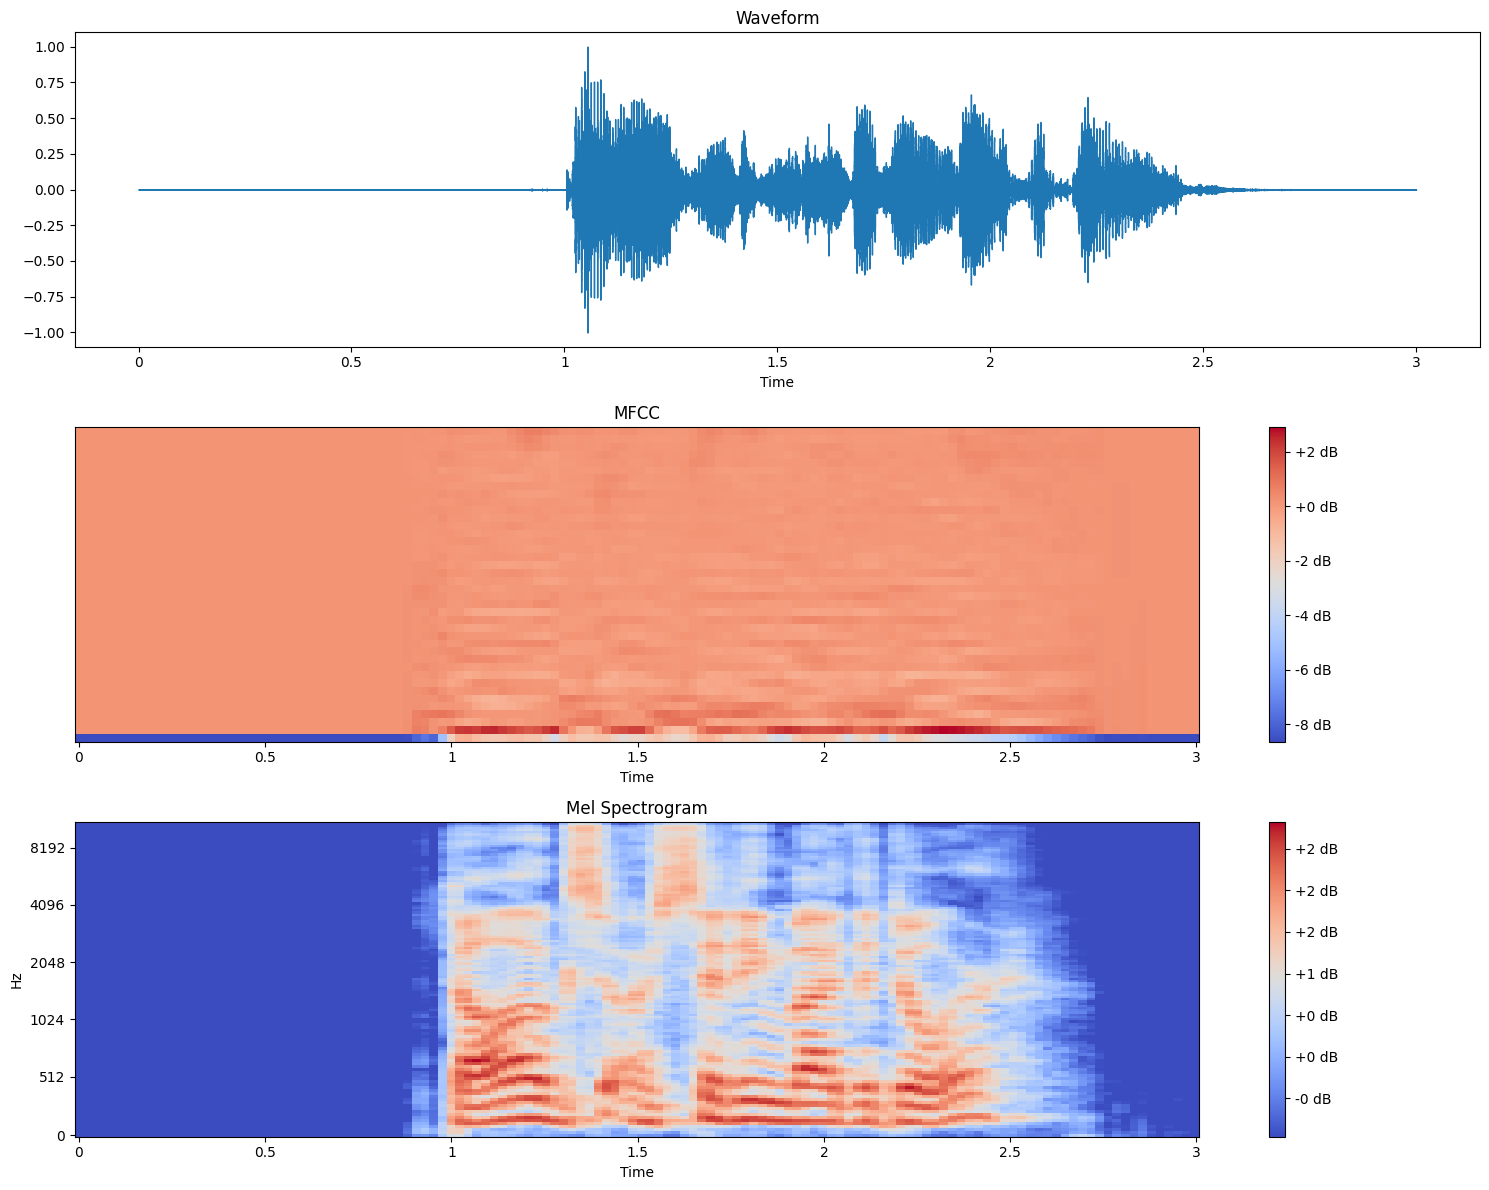

MFCC shape: (40, 130)
Melspec shape : (128, 130)


In [18]:
#testing our preprocessing functions with the sample file
sample_file = ravdess_files[0]

y, sr = load_audio(sample_file)
mfcc = extract_mfcc(y, sr)
melspec = extract_melspec(y, sr)

# Plot waveform
plt.figure(figsize=(15, 12))

plt.subplot(3, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')


# Plot MFCC
plt.subplot(3, 1, 2)
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')

# Plot Mel Spectrogram
plt.subplot(3, 1, 3)
librosa.display.specshow(melspec, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')

plt.tight_layout()
plt.show()

print(f"MFCC shape: {mfcc.shape}")
print(f"Melspec shape : {melspec.shape}")

We have extracted the three features of the audio.

Melspec preserves the timbral information of the audio, making it a perfect fit for emotion detection.

We will be using a combination of mfcc and melspec to get better results.

Lets make our CNN model architecture

In [19]:
class AudioCNN(nn.Module):
    def __init__(self):
        super(AudioCNN, self).__init__()

        #layer1 (2 input channels melspec and mfcc)
        self.conv1 = nn.Conv2d(2, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2)


        self.fc1 = nn.Linear(64 * 5 * 16, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.7)
        self.fc2 = nn.Linear(128, 8)


    def forward(self,x):
        batch_size = x.size(0)

        #TODO: specaugment
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x



Lets write a function to train the model

In [20]:
def train_model(model, train_loader, val_loader,criterion, optimizer, scheduler, num_epochs=30):
    train_losses= []
    val_losses= []
    train_accs= []
    val_accs= []

    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # print(f"Starting epoch {epoch+1}/{num_epochs} (Training)")

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # if (batch_idx + 1) % 10 == 0:
                # print(f"  Batch {batch_idx + 1}/{len(train_loader)}, Loss: {loss.item():.4f}, Acc: {correct/total:.4f}")
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = 100 * correct / total
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)


        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        # print(f"Starting epoch {epoch+1}/{num_epochs} (Validation)")

        with torch.no_grad():
            for batch_idx, (inputs, labels) in enumerate(val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Calculate metrics
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate epoch metrics
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = 100 * val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)
        
        # Print epoch results
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"  Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_acc:.2f}%")
        print(f"  Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_acc:.2f}%")
        
        # Update learning rate
        scheduler.step(epoch_val_loss)

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_state = model.state_dict().copy()
            print(f"  New best model saved! (Val Loss: {best_val_loss:.4f})")


    model.load_state_dict(best_model_state)
    print("Training complete! Loaded the best model.")
    
    return model, train_losses, val_losses, train_accs, val_accs

lets train it

In [ ]:
model = AudioCNN().to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr = 0.0003, weight_decay=0.002)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5,  min_lr=0.00001)

# Train the model
model, train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30
)

/Users/hanumac/Desktop/programming/Python/sharedEnv/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30:
  Train Loss: 2.1238, Train Accuracy: 21.13%
  Val Loss: 1.8438, Val Accuracy: 33.56%
  New best model saved! (Val Loss: 1.8438)
Epoch 2/30:
  Train Loss: 1.9271, Train Accuracy: 31.15%
  Val Loss: 1.7243, Val Accuracy: 41.44%
  New best model saved! (Val Loss: 1.7243)
Epoch 3/30:
  Train Loss: 1.7807, Train Accuracy: 38.49%
  Val Loss: 1.6701, Val Accuracy: 42.82%
  New best model saved! (Val Loss: 1.6701)
Epoch 4/30:
  Train Loss: 1.6994, Train Accuracy: 42.86%
  Val Loss: 1.5599, Val Accuracy: 49.77%
  New best model saved! (Val Loss: 1.5599)
Epoch 5/30:
  Train Loss: 1.6179, Train Accuracy: 46.43%
  Val Loss: 1.5284, Val Accuracy: 51.16%
  New best model saved! (Val Loss: 1.5284)
Epoch 6/30:
  Train Loss: 1.5249, Train Accuracy: 51.88%
  Val Loss: 1.4582, Val Accuracy: 56.25%
  New best model saved! (Val Loss: 1.4582)
Epoch 7/30:
  Train Loss: 1.5014, Train Accuracy: 52.78%
  Val Loss: 1.5526, Val Accuracy: 50.00%
Epoch 8/30:
  Train Loss: 1.4391, Train Accuracy: 57.34%

lets plot the loss and accuracy vs epochs

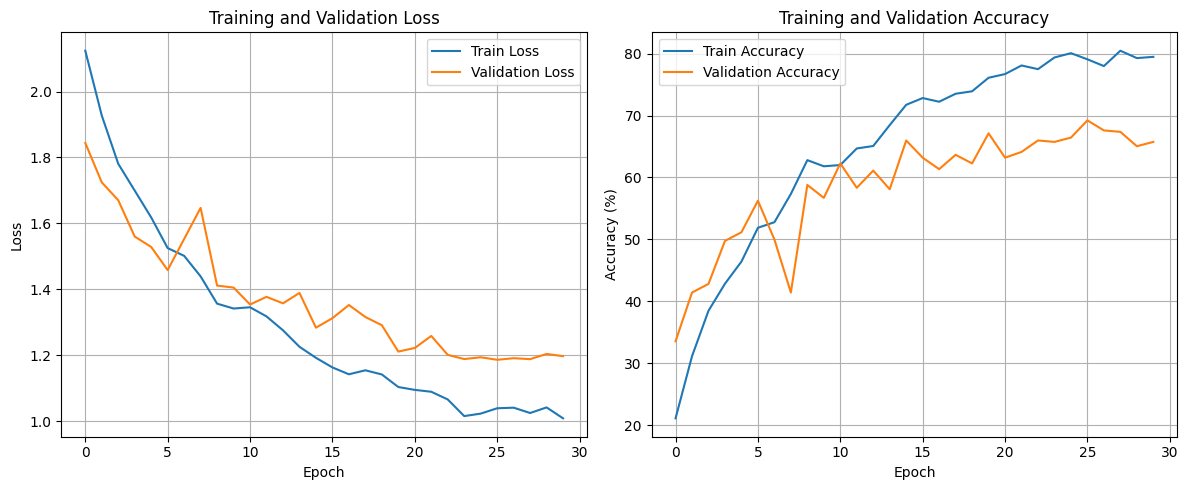

In [22]:
# Plot training and validation metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

to evaluate the model

In [23]:
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

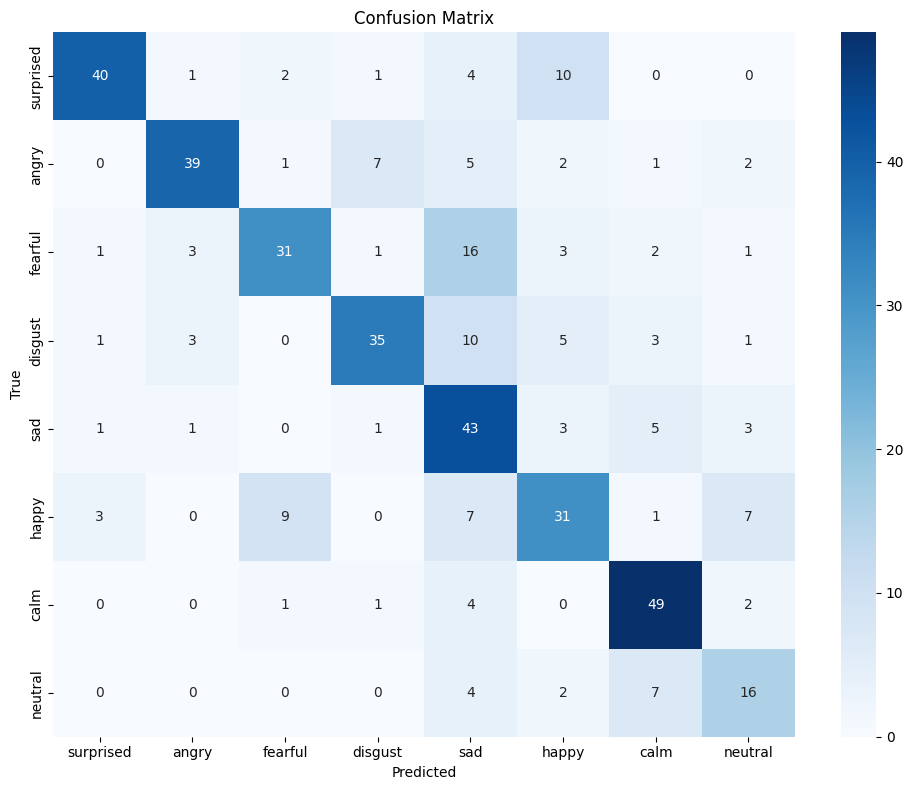

Classification Report:
               precision    recall  f1-score   support

   surprised      0.870     0.690     0.769        58
       angry      0.830     0.684     0.750        57
     fearful      0.705     0.534     0.608        58
     disgust      0.761     0.603     0.673        58
         sad      0.462     0.754     0.573        57
       happy      0.554     0.534     0.544        58
        calm      0.721     0.860     0.784        57
     neutral      0.500     0.552     0.525        29

    accuracy                          0.657       432
   macro avg      0.675     0.652     0.653       432
weighted avg      0.687     0.657     0.662       432



In [24]:
# Evaluate on validation set
val_preds, val_labels = evaluate_model(model, val_loader)
cm = confusion_matrix(val_labels, val_preds)
emotion_names = list(id_to_emotion.values())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_names, yticklabels=emotion_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


report = classification_report(val_labels, val_preds, target_names=emotion_names, digits=3)
print("Classification Report:\n", report)

In [25]:
def predict_emotion(model, file_path):
    y, sr = load_audio(file_path)
    mfcc = extract_mfcc(y, sr)
    melspec = extract_melspec(y, sr)
    if melspec.shape[0] != 40:
        melspec = librosa.util.fix_length(melspec, size=40, axis=0)
    features = np.stack([mfcc, melspec], axis=0)
    features = torch.FloatTensor(features).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(features)
        probs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
    emotion_id = predicted.item()
    emotion = id_to_emotion[emotion_id]
    probability = probs[0][emotion_id].item()
    emotion_probs = {id_to_emotion[i]: probs[0][i].item() for i in range(len(id_to_emotion))}
    return emotion, probability, emotion_probs

Lets test it on 5 random samples from the dataset.

Sample 1: 03-01-01-01-02-02-05.wav
True emotion: neutral
Predicted emotion: sad with 34.50% confidence


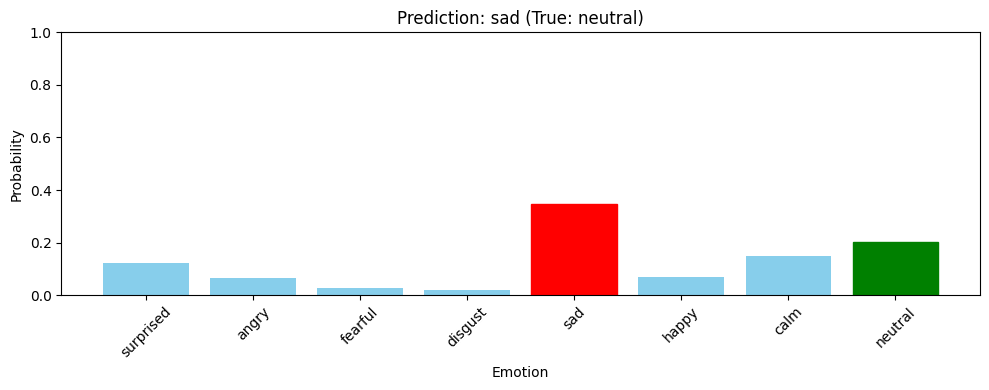

--------------------------------------------------
Sample 2: 03-01-07-01-02-01-07.wav
True emotion: disgust
Predicted emotion: happy with 19.88% confidence


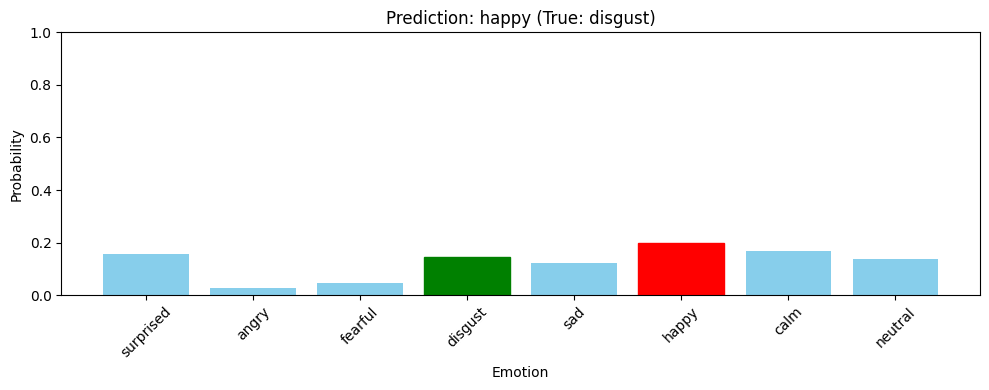

--------------------------------------------------
Sample 3: 03-01-05-01-02-01-11.wav
True emotion: angry
Predicted emotion: angry with 54.36% confidence


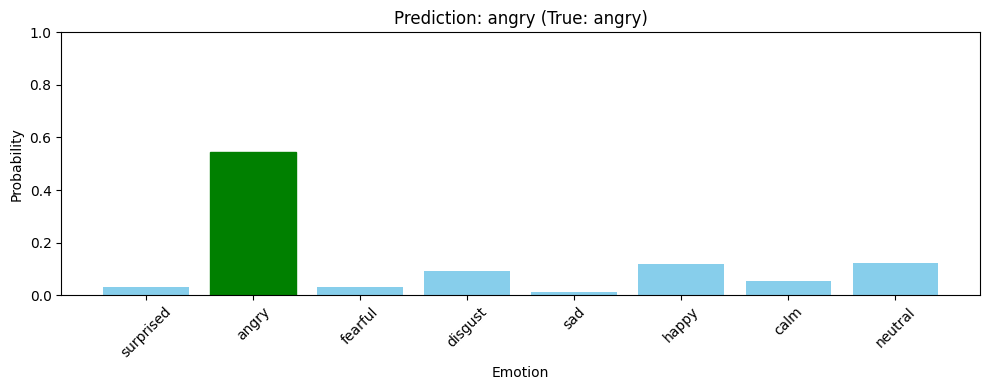

--------------------------------------------------
Sample 4: 03-01-03-02-02-02-11.wav
True emotion: happy
Predicted emotion: sad with 25.32% confidence


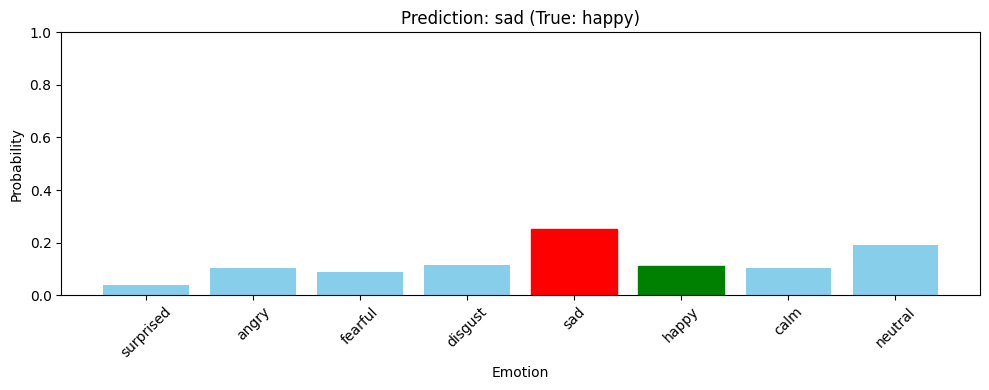

--------------------------------------------------
Sample 5: 03-01-01-01-01-02-01.wav
True emotion: neutral
Predicted emotion: neutral with 50.26% confidence


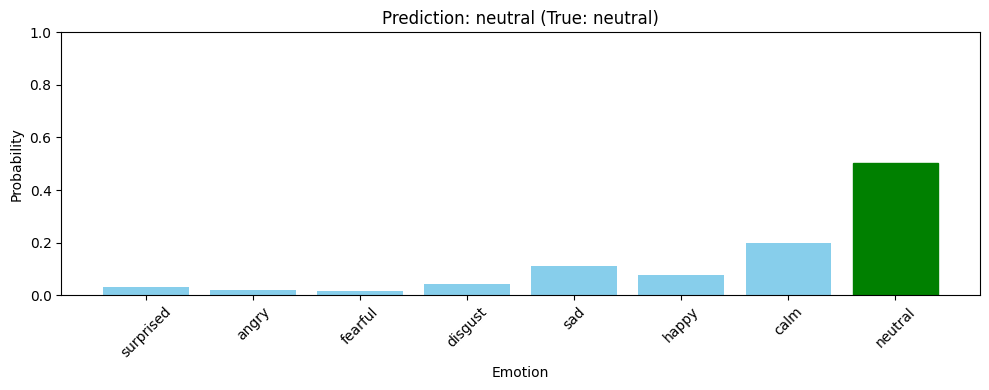

--------------------------------------------------


In [26]:
test_samples = val_df.sample(5)['filepath'].tolist()
for i, sample in enumerate(test_samples):
    # Get actual and predicted emotions
    actual_emotion = get_file_meta(sample)['emotion']
    pred_emotion, confidence, all_probs = predict_emotion(model, sample)
    
    # Print basic information
    print(f"Sample {i+1}: {os.path.basename(sample)}")
    print(f"True emotion: {actual_emotion}")
    print(f"Predicted emotion: {pred_emotion} with {confidence*100:.2f}% confidence")
    
    # Plot only the probability distribution
    plt.figure(figsize=(10, 4))
    emotions = list(all_probs.keys())
    probs = list(all_probs.values())
    bars = plt.bar(emotions, probs, color='skyblue')
    
    # Highlight the true and predicted emotions
    for j, emotion in enumerate(emotions):
        if emotion == actual_emotion:
            bars[j].set_color('green')
        elif emotion == pred_emotion and pred_emotion != actual_emotion:
            bars[j].set_color('red')
    
    plt.xlabel('Emotion')
    plt.ylabel('Probability')
    plt.title(f'Prediction: {pred_emotion} (True: {actual_emotion})')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    print("-" * 50)

In [27]:
torch.save(model.state_dict(), 'audio_emotion_model.pth')

# Save emotion mappings
with open('emotion_mappings.json', 'w') as f:
    json.dump({
        'emotion_to_id': {emotion: idx for emotion, idx in emotion_to_id.items()},
        'id_to_emotion': {str(idx): emotion for idx, emotion in id_to_emotion.items()}
    }, f)

print("Model and mappings saved successfully")

Model and mappings saved successfully
